# Extracting Signatures from Document Images Using Connected Components Analysis

In this notebook we show how to extract signatures from scanned or photographed document pictures using computer vision techniques. It specifically uses Connected Components Analysis (CCA) to detect regions of interest within a binarized document picture. The procedure consists of importing and preprocessing a picture, separating related components based on size, and filtering for regions likely to contain signatures. The separated components are then stored as separate picture files for later processing or storage. This approach is beneficial for automated signature extraction in applications such as document verification and archiving.

# 1. Imports 

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 2. Define utility functions
This cell defines two utility functions:

- display_image: A helper function to visualize images using Matplotlib.
- extract_signatures: A function that applies Connected Components Analysis (CCA) to identify connected regions in a binary image and filters them based on area constraints, isolating potential signatures.

In [7]:
def display_image(image, title="Image", cmap='gray'):
    """Utility function to display an image."""
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def extract_signatures(image, min_area=100, max_area=2000, min_aspect_ratio=1.5, max_aspect_ratio=6.0):
    """
    Extracts connected components that could correspond to signatures.
    
    Parameters:
        image (numpy.ndarray): Binary image.
        min_area (int): Minimum area of a connected component.
        max_area (int): Maximum area of a connected component.
        min_aspect_ratio (float): Minimum aspect ratio (width/height) of a component.
        max_aspect_ratio (float): Maximum aspect ratio (width/height) of a component.
        
    Returns:
        list: List of bounding boxes for the extracted components.
    """
    # Perform connected components analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)

    # Filter components based on size and aspect ratio
    extracted_boxes = []
    for i in range(1, num_labels):  # Skip the background (label 0)
        x, y, w, h, area = stats[i]
        aspect_ratio = w / h
        if min_area < area < max_area and min_aspect_ratio < aspect_ratio < max_aspect_ratio:
            extracted_boxes.append((x, y, w, h))
    return extracted_boxes


# 3. Load and preprocess the document image
This cell loads the input document image in grayscale format and preprocesses it for analysis. It applies Otsu's thresholding to convert the image into a binary format, inverting the colors so that the foreground (text and signatures) appears white on a black background. The binary image is displayed for verification.

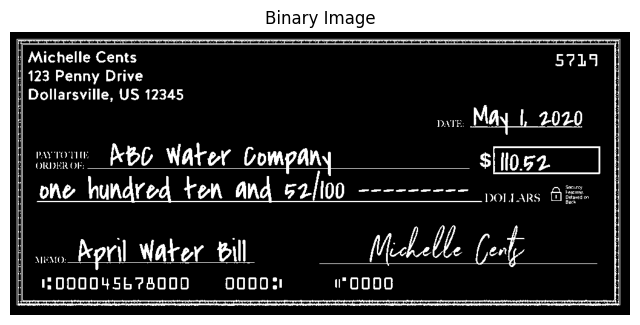

In [6]:
# Load image
image_path = "example.jpg"  # Update with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Binarize the image using Otsu's thresholding
_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Display the binary image
display_image(binary_image, "Binary Image")


# 4. Extract potential signatures
This cell uses the previously defined extract_signatures function to identify connected components that match the size criteria for signatures. Bounding boxes are drawn around the identified regions, and the processed image is displayed to visualize the results.

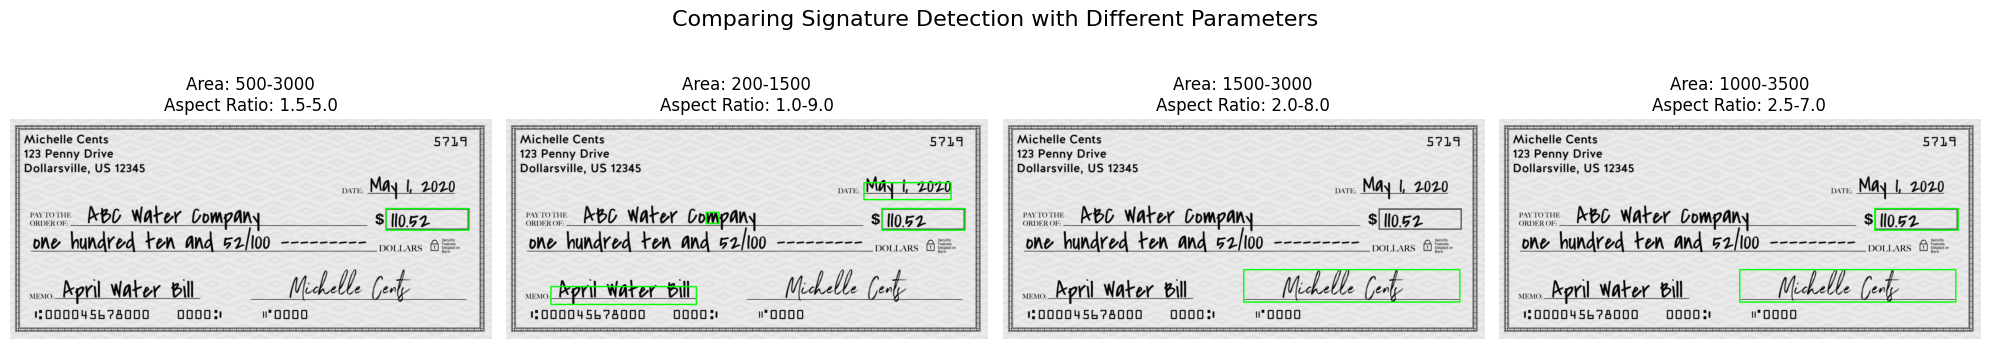

In [22]:
# Define parameter combinations to test
parameter_sets = [
    {"min_area": 500, "max_area": 3000, "min_aspect_ratio": 1.5, "max_aspect_ratio": 5.0},
    {"min_area": 200, "max_area": 1500, "min_aspect_ratio": 1.0, "max_aspect_ratio": 9.0},
    {"min_area": 1500, "max_area": 3000, "min_aspect_ratio": 2.0, "max_aspect_ratio": 8.0}, 
    {"min_area": 1000, "max_area": 3500, "min_aspect_ratio": 2.5, "max_aspect_ratio": 7.0},
]

# Prepare a figure for displaying the results
fig, axes = plt.subplots(1, len(parameter_sets), figsize=(20, 4))
fig.suptitle("Comparing Signature Detection with Different Parameters", fontsize=16)

# Process each parameter set and visualize the results
for i, params in enumerate(parameter_sets):
    # Extract signatures using the current parameter set
    signature_boxes = extract_signatures(
        binary_image, 
        min_area=params["min_area"], 
        max_area=params["max_area"], 
        min_aspect_ratio=params["min_aspect_ratio"], 
        max_aspect_ratio=params["max_aspect_ratio"]
    )
    
    # Create a copy of the original image with bounding boxes
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for x, y, w, h in signature_boxes:
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Plot the result
    axes[i].imshow(output_image)
    axes[i].set_title(
        f"Area: {params['min_area']}-{params['max_area']}\n"
        f"Aspect Ratio: {params['min_aspect_ratio']}-{params['max_aspect_ratio']}"
    )
    axes[i].axis("off")

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Best parameter combination

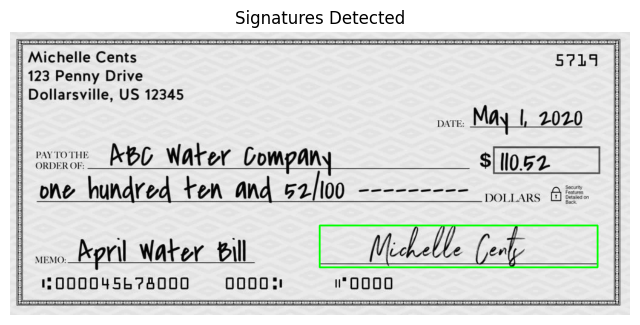

In [19]:
min_area = 1500      # Minimum area of a component
max_area = 3000     # Maximum area of a component
min_aspect_ratio = 2.0  # Minimum aspect ratio
max_aspect_ratio = 8.0  # Maximum aspect ratio

signature_boxes = extract_signatures(binary_image, min_area, max_area, min_aspect_ratio, max_aspect_ratio)

# Draw bounding boxes around detected signatures
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for x, y, w, h in signature_boxes:
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with bounding boxes
display_image(output_image, "Signatures Detected")


# Automating the Process
In this part we adapt the pipe;ine proposed [here](https://github.com/EnzoSeason/signature_detection.git) to try and automate the process of extraction to be more generic for all data.

In [2]:
from utils.loader import Loader
from utils.extractor import Extractor
from utils.cropper import Cropper
from utils.judger import Judger

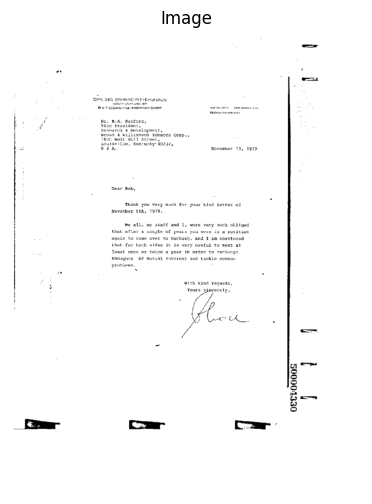

In [29]:
image_path = '/home/omar/Masters/Adv Image and Video Processiong/Project/Dataset/40gigs_signatures_imgs/0000003302.png'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
display_image(image)

## Loader

The loader reads the file and creates a mask. 

The mask is a numpy array. The bright parts are set to 255, the rest is set to 0.

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[  0 255]


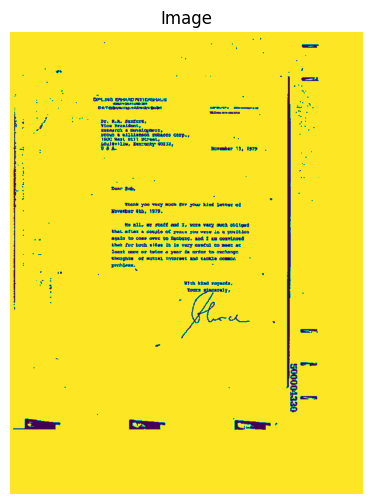

In [11]:
loader = Loader()
mask = loader.get_masks(image_path)[0]
print(mask)
print(np.unique(mask))
display_image(mask,cmap=None)

## Extractor

The extractor 

1. generates the regions from the mask.
2. removes the small and the big region because the signature is neither too big nor too small.

[  0 255]


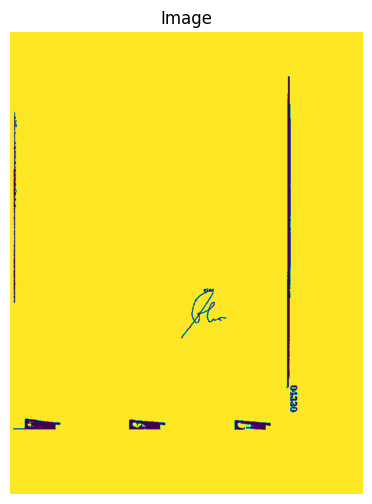

In [12]:
extractor = Extractor(amplfier=15)
labeled_mask = extractor.extract(mask)
print(np.unique(labeled_mask))
display_image(labeled_mask,cmap=None)
# plt.imsave('./data/output/labeled_mask.jpeg', labeled_mask)

## Cropper

The cropper finds the **contours** of regions in the **labeled masks** and crop them.

{0: {'cropped_region': array([369, 554,  99, 110]), 'cropped_mask': array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255,   0,   0, ..., 255, 255, 255],
       [255,   0,   0, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)}}


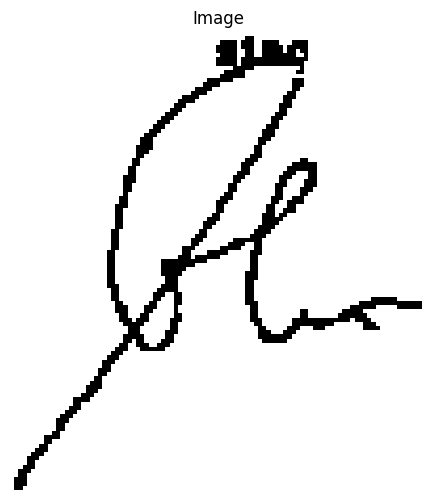

In [13]:
cropper = Cropper()
results = cropper.run(labeled_mask)
print(results)
signature = results[0]["cropped_mask"]
# print(np.unique(signature))
display_image(signature)

In [ ]:
def process_image(image_path):
    """
    Process an image to extract and display its original content, intermediate masks, 
    and final signature masks.
    
    Parameters:
    - image_path: str, the path to the input image.
    """
    # Load and display the original image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not read image from path: {image_path}")
        return
    display_image(image, title='Original Image')

    # Load the mask using the Loader
    loader = Loader()
    masks = loader.get_masks(image_path)
    if not masks:
        print("Error: No masks generated.")
        return
    
    mask = masks[0]
    # print(f"Mask:\n{mask}")
    # print(f"Unique values in mask: {np.unique(mask)}")
    # display_image(mask, cmap=None, title='Intermediate Mask')

    # Extract labeled regions using the Extractor
    extractor = Extractor(amplfier=15)
    labeled_mask = extractor.extract(mask)
    # print(f"Unique values in labeled mask: {np.unique(labeled_mask)}")
    # display_image(labeled_mask, cmap=None, title='Labeled Mask')

    # Crop the labeled regions using the Cropper
    cropper = Cropper()
    results = cropper.run(labeled_mask)
    if not results:
        print("Error: No signatures extracted.")
        return
    
    # Display each extracted signature
    for idx, result in enumerate(results):
        signature = results[idx]["cropped_mask"]
        print(f"Displaying signature {idx + 1}")
        display_image(signature, title=f'Signature {idx + 1}')

# Some examples

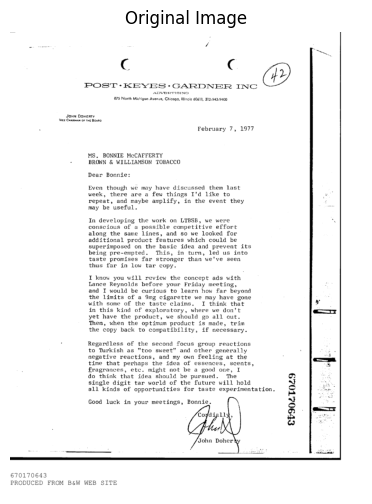

Displaying signature 1


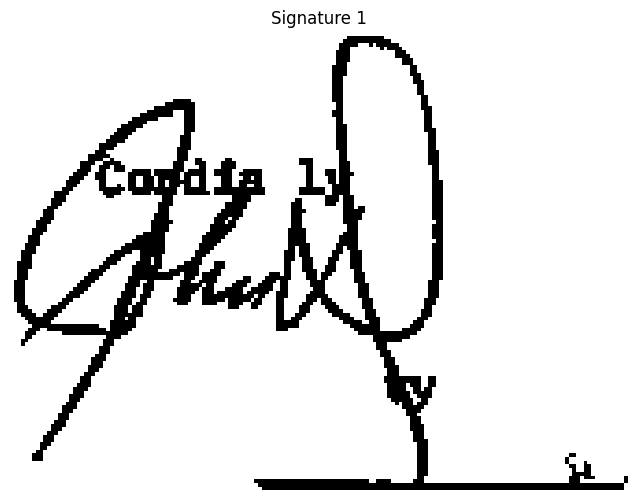

In [56]:
image_path = '/home/omar/Masters/Adv Image and Video Processiong/Project/Dataset/40gigs_signatures_imgs/674723.png'

process_image(image_path)

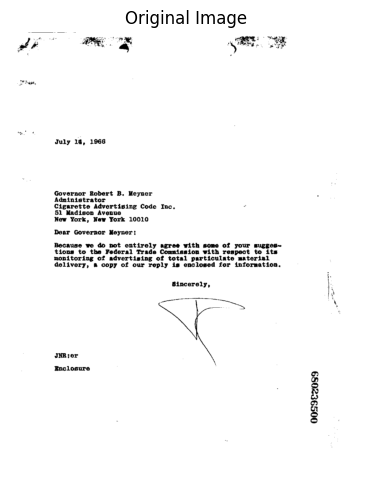

Displaying signature 1


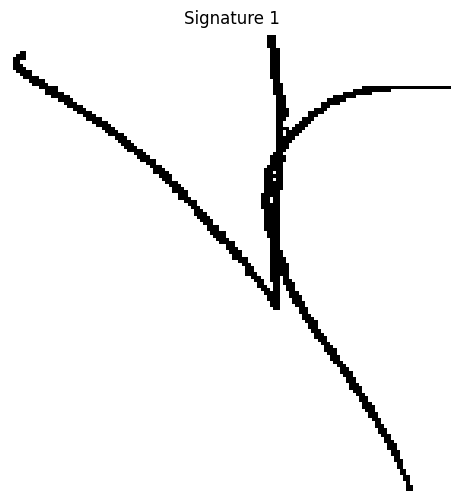

In [60]:
image_path = '/home/omar/Masters/Adv Image and Video Processiong/Project/Dataset/40gigs_signatures_imgs/0000281345.png'

process_image(image_path)

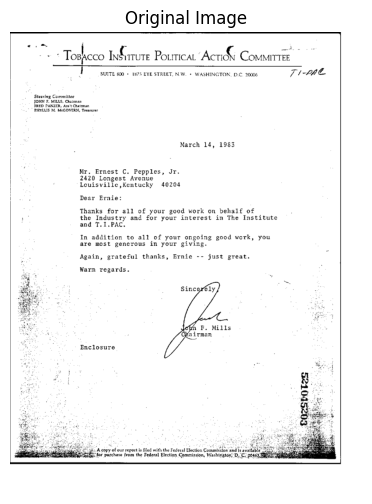

Displaying signature 1


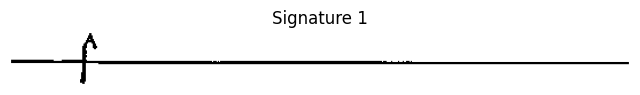

Displaying signature 2


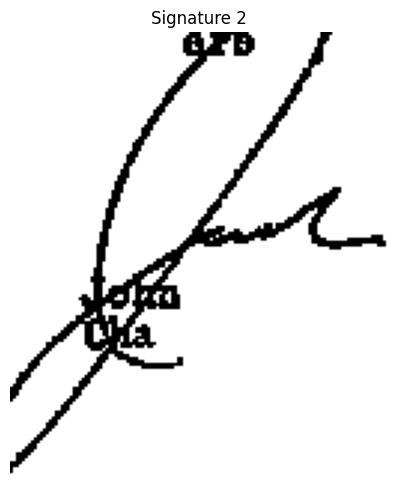

In [67]:
image_path = '/home/omar/Masters/Adv Image and Video Processiong/Project/Dataset/40gigs_signatures_imgs/0000156649.png'

process_image(image_path)